# ___

# [ Machine Learning in Geosciences ]

**Department of Applied Geoinformatics and Carthography, Charles University** 

*Lukas Brodsky lukas.brodsky@natur.cuni.cz*

    
___



# End-to-End Machine Learning Project!


1/ Describe the Task

2/ Get and Explore the Data

3/ Prepare the Data for ML Algorithms!

4/ Select and Train a Model

5/ Fine-Tune the Model!

6/ Interpret the results

___    

# 1/ The Problem 

**1.1 Frame the problem:** 
The task is to build a model of housing prices in California using the California census data to be able to predict the median housing price in any district. 

**Assumptions of the problem:** 
* There exist some (most likely non-linear) relationship between input features (X) and the output target  variable (y); 
* the output target is a continuous variable, hence we employ regression type of model; 
* There are multiple features, hence multivariate regression; 
* There is no continuous flow of data -> batch learning;

**1.2 The expected result:** 
The developed model shall predict housing prices based set of characteristics (fetures) with error < 20 %. 


**Performance measures:** 
* RMSE or MAE; 
* How much we know about the data? -> Update after EDA. 



# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt 

# Sklearn 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestRegressor

# to make this notebook's output stable across runs
np.random.seed(42)
# To plot 'pretty' figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

# SET PATH TO YOUR PROJECT DIRECTORY!
PROJECT_ROOT_DIR = "./"
if os.path.isdir(PROJECT_ROOT_DIR): 
    print('Ok continue.')
else: 
    print('Nok, set correct path to your project directory!')

# Set path to save project figures 
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="internal gelsd")

C:\Users\uzivatel\AppData\Local\Temp\ipykernel_5256\353833620.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Ok continue.


# 2/ Exploratory Data Analysis


In [2]:
# Inport data 
HOUSING_PATH = os.path.join(PROJECT_ROOT_DIR)
# print(HOUSING_PATH)

# function to read the csv file 
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
# load data 
housing = load_housing_data()

# check header and some values 
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# evaluate the values, overall info about the data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# Evaluate statistics of the features 
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
# features 
# housing_columns = list(housing.columns)
# housing_columns

### 2.1 Visualize the data to gain insights

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

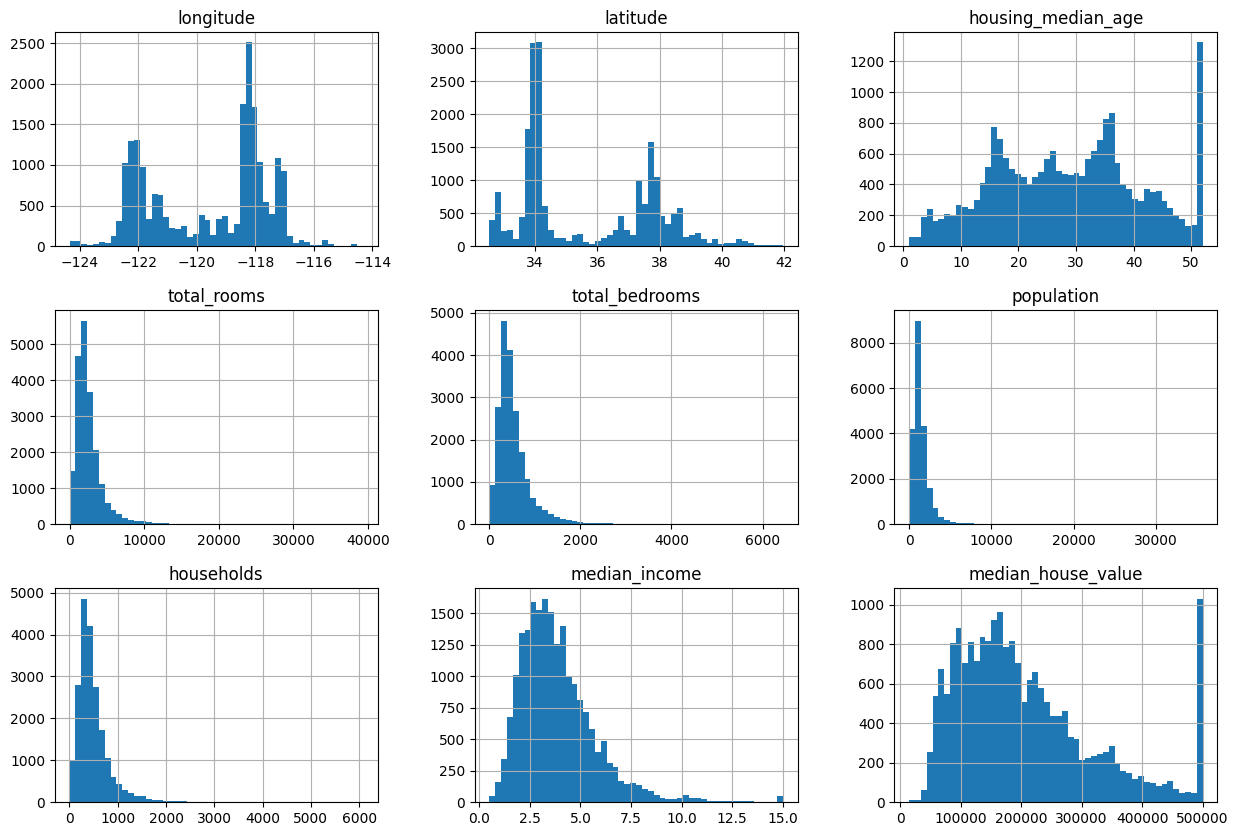

In [6]:
# histograms, pandas umí udělat histogram, nepotřebujeme matplotlib
housing.hist(bins=50, figsize=(15,10))
# save_fig("attribute_histogram_plots") 

In [ ]:
# u housign_meadian_age a madeian_house_value jsou hodně odskočený okrajový hodnoty, mohlo by to pak dělat problém u RMSE

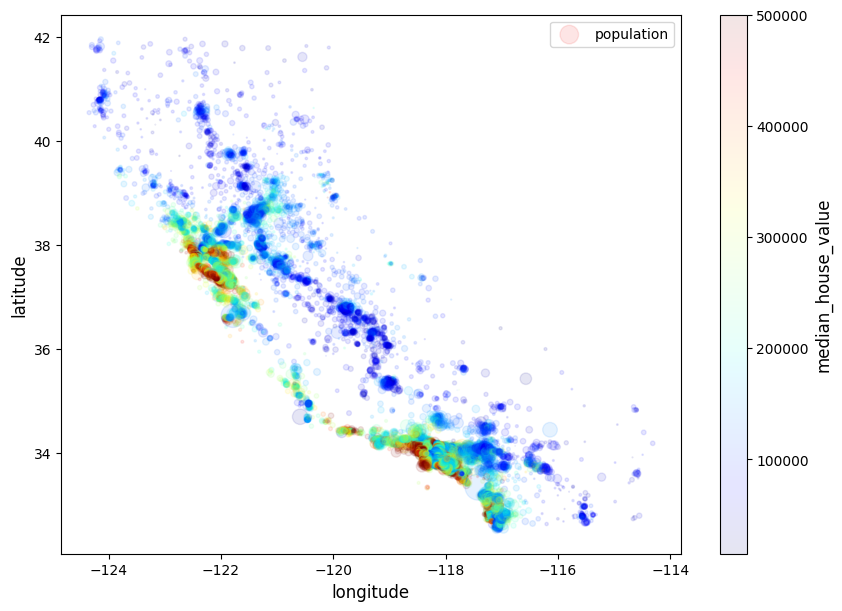

In [7]:
# plot housing data (spatial plot )
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1,
             c="median_house_value",
             s=housing["population"]/100, label="population", figsize=(10,7),
             cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
# save_fig("housing_prices_scatterplot")
# šel by do toho přidat obrázek/data s hranicemi Kalifornie

### 2.2 Looking for Correlations

In [8]:
# Remove non-numeric data, zůstanou tam jen real values → rval
housing_rval = housing.drop('ocean_proximity', axis=1)
# housing_rval.head()

In [9]:
# Prepare correlation data 
corr_matrix = housing_rval.corr()

In [10]:
# jak data korelují s median_house_value
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

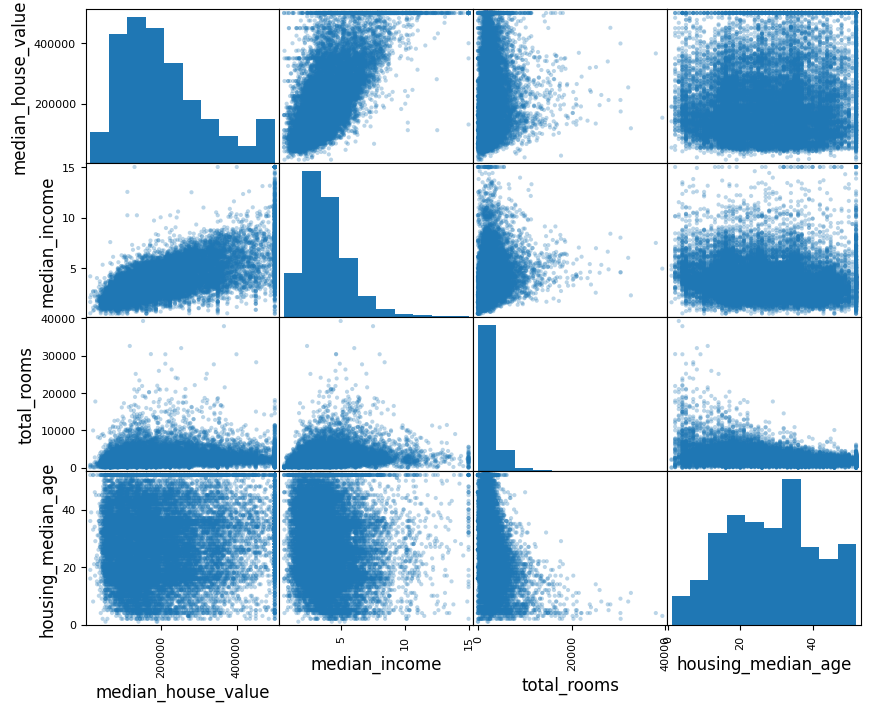

In [13]:
# cross-scatterplot for selected features 
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(10, 8), alpha=0.3)
# save_fig("scatter_matrix_plot")

(0.0, 16.0, 0.0, 550000.0)

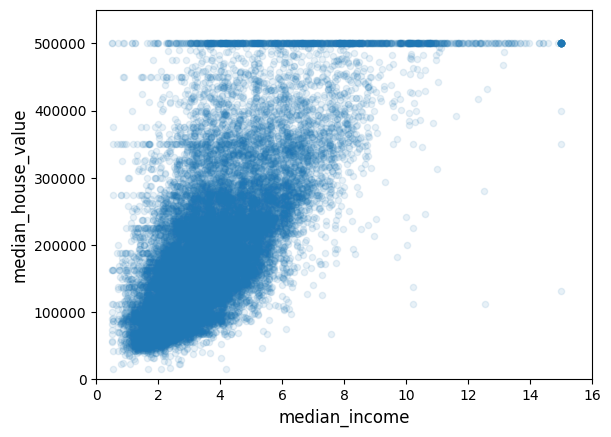

In [12]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
# save_fig("income_vs_house_value_scatterplot")

In [ ]:
# v grafíku nahoře ta lajna jsou ty odskočený hodnoty ze začátku

### 2.3 Experiment with Attributes 
.. later on in data preparation. 

# 3. Data preparation

### 3.1 Prepare the data for Machine Learning algorithms - Feature Engineering

In [14]:
housing.shape

(20640, 10)

### New fetures

In [15]:
# add some more features (relative indicators) 
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [16]:
housing.columns #nepotřebujeme to

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'rooms_per_household',
       'bedrooms_per_room', 'population_per_household'],
      dtype='object')

In [17]:
housing.shape

(20640, 13)

In [18]:
# tohle taky nepotřebujeme

# Append new feature names to the list of columns 
housing_columns.append('rooms_per_household')
housing_columns.append('bedrooms_per_room')
housing_columns.append('population_per_household')
housing_columns

NameError: name 'housing_columns' is not defined

### Check correlations

In [19]:
housing_rval = housing.drop('ocean_proximity', axis=1)

In [20]:
# zlepšila se korelace s novými features?
corr_matrix = housing_rval.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

### 3.2 Fill no-data values or drop incomplete records

In [21]:
# Which records have NaN record?
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY,5.761468,NaN,2.614679
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY,3.830116,NaN,2.826255
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY,4.048704,NaN,2.938727
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY,6.102740,NaN,2.630137
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY,4.633540,NaN,2.403727


In [22]:
sample_incomplete_rows.shape

(5, 13)

### Drop NaN records 

In [ ]:
# Option 1: .dropna()
# sample_incomplete_rows.dropna(subset=["total_bedrooms"])    

In [ ]:
# Option 2: .drop()
# sample_incomplete_rows.drop("total_bedrooms", axis=1)       

### Fill-in meadian value 

In [23]:
# Option 3: fill-in meadian value 
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) 
sample_incomplete_rows

C:\Users\uzivatel\AppData\Local\Temp\ipykernel_5256\3148037631.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
290,-122.16,37.77,47.0,1256.0,435.0,570.0,218.0,4.3750,161900.0,NEAR BAY,5.761468,NaN,2.614679
341,-122.17,37.75,38.0,992.0,435.0,732.0,259.0,1.6196,85100.0,NEAR BAY,3.830116,NaN,2.826255
538,-122.28,37.78,29.0,5154.0,435.0,3741.0,1273.0,2.5762,173400.0,NEAR BAY,4.048704,NaN,2.938727
563,-122.24,37.75,45.0,891.0,435.0,384.0,146.0,4.9489,247100.0,NEAR BAY,6.102740,NaN,2.630137
696,-122.10,37.69,41.0,746.0,435.0,387.0,161.0,3.9063,178400.0,NEAR BAY,4.633540,NaN,2.403727


### Sklearn Imputer

In [25]:
# 4. možnost, imputer spočítá medián
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

In [26]:
# Remove the text attribute because median can only be calculated on numerical attributes:
housing_num = housing.drop('ocean_proximity', axis=1)
# housing_num

In [27]:
# fit the imputer instance to the training data using the fit() method
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [28]:
# vrátí medián pro každý sloupec asi?
imputer.statistics_

array([-1.18490000e+02,  3.42600000e+01,  2.90000000e+01,  2.12700000e+03,
        4.35000000e+02,  1.16600000e+03,  4.09000000e+02,  3.53480000e+00,
        1.79700000e+05,  5.22912879e+00,  2.03162434e-01,  2.81811565e+00])

In [29]:
# Check that this is the same as manually computing the median of each attribute:
housing_num.median().values

array([-1.18490000e+02,  3.42600000e+01,  2.90000000e+01,  2.12700000e+03,
        4.35000000e+02,  1.16600000e+03,  4.09000000e+02,  3.53480000e+00,
        1.79700000e+05,  5.22912879e+00,  2.03162434e-01,  2.81811565e+00])

In [30]:
# Now we can use this “trained” imputer to transform the training set 
# by replacing missing values by the learned medians

housing_num_imp = imputer.transform(housing_num)

# Numpy array containing the transformed features
print(type(housing_num_imp))

<class 'numpy.ndarray'>


In [31]:
# put it back into a Pandas DataFrame
housing_num_tr = pd.DataFrame(housing_num_imp, columns=housing_num.columns,
                          index=housing.index)

In [32]:
# check the imputation, locate values which were NaN before
housing_num_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
290,-122.16,37.77,47.0,1256.0,435.0,570.0,218.0,4.3750,161900.0,5.761468,0.203162,2.614679
341,-122.17,37.75,38.0,992.0,435.0,732.0,259.0,1.6196,85100.0,3.830116,0.203162,2.826255
538,-122.28,37.78,29.0,5154.0,435.0,3741.0,1273.0,2.5762,173400.0,4.048704,0.203162,2.938727
563,-122.24,37.75,45.0,891.0,435.0,384.0,146.0,4.9489,247100.0,6.102740,0.203162,2.630137
696,-122.10,37.69,41.0,746.0,435.0,387.0,161.0,3.9063,178400.0,4.633540,0.203162,2.403727


In [33]:
imputer.strategy

'median'

In [34]:
housing_num_tr.shape

(20640, 12)

In [ ]:
# Scale the numerical features: housing_num
# scaler = StandardScaler()
# scaler.fit(housing_num)
# scaler.mean_
# housing_num_scaled = scaler.transform(housing_num)

In [ ]:
# type(housing_num_scaled)

In [ ]:
# put it back into a Pandas DataFrame
# housing_num_scaled = pd.DataFrame(housing_num_scaled, columns=housing_num.columns,
#                           index=housing.index)

In [ ]:
# housing_num_scaled.head()

In [ ]:
# housing_num_scaled.shape

### 3.3 Harmonize numerical data
### Feature Endcoding 

Transform cathegorical text feature(s) into numerical. 

In [35]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn > 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

In [36]:
housing["ocean_proximity"]

0        NEAR BAY
1        NEAR BAY
2        NEAR BAY
3        NEAR BAY
4        NEAR BAY
           ...   
20635      INLAND
20636      INLAND
20637      INLAND
20638      INLAND
20639      INLAND
Name: ocean_proximity, Length: 20640, dtype: object

In [38]:
housing["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [ ]:
# máme pět unique values, takže OnehotEncoder přidá do dat pět nových řádků

In [37]:
housing["ocean_proximity"].shape 

(20640,)

In [39]:
# encoder = OneHotEncoder()
encoder= OneHotEncoder(sparse_output=False).set_output(transform="pandas") # vrátí pandas dataframe
encoder.fit(housing[["ocean_proximity"]])
ocean_proximity_num = encoder.transform(housing[["ocean_proximity"]]) # bude to pandas dataframe

In [40]:
type(ocean_proximity_num)

pandas.core.frame.DataFrame

In [41]:
ocean_proximity_num.head()

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0


In [42]:
housing_num_tr.shape

(20640, 12)

In [43]:
ocean_proximity_num.shape

(20640, 5)

In [ ]:
# máme 12 sloupců z původních dat a 5 nových, které chceme přidat, musíme zmergovat data

In [44]:
# Merge the two DataFrames
housing_num_enc_merged = pd.concat([housing_num_tr, ocean_proximity_num], axis=1)
housing_num_enc_merged.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,6.984127,0.146591,2.555556,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,6.238137,0.155797,2.109842,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,8.288136,0.129516,2.802260,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,5.817352,0.184458,2.547945,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,6.281853,0.172096,2.181467,0.0,0.0,0.0,1.0,0.0


In [45]:
housing_num_enc_merged.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'rooms_per_household', 'bedrooms_per_room',
       'population_per_household', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')

In [46]:
housing_num_enc_merged.shape

(20640, 17)

In [ ]:
# housing_columns.remove('ocean_proximity')

In [ ]:
# for item in list(ocean_proximity_num.columns):
#         housing_columns.append(item)

In [ ]:
# housing_columns

### 3.4 Split Data set into Training and Test Sets

Options: 

    * random sampling (introducing a significant sampling bias); 
    * stratified sampling (to ensure that split sample is representative of the whole populatio); 
    

### Numpy random solution

In [47]:
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) # přidává extra permutace, randomizace dat
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# pokud mám data nějak seřazená, tak je lepší na ně pustit shuffle

In [48]:
train_set, test_set = split_train_test(housing_num_enc_merged, 0.5)
print(f'Train set size: {len(train_set)}, Test set size: {len(test_set)}')

Train set size: 10320, Test set size: 10320


### Scikit learn split functions

To make repeated experiments set `random_state` to some constatnt!

In [49]:
# split 
train_set, test_set = train_test_split(housing_num_enc_merged, test_size=0.5, random_state=42)

In [50]:
print(f'Train set size: {len(train_set)}, Test set size: {len(test_set)}')

Train set size: 10320, Test set size: 10320


### Stratified sampling


<Axes: >

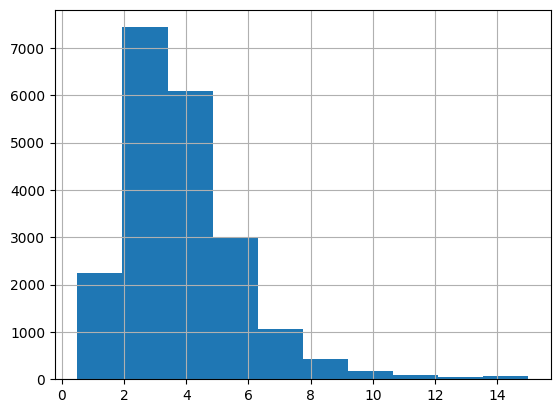

In [51]:
# check histogram 
housing_num_enc_merged["median_income"].hist()

In [52]:
# cut the histogram into bins 
housing_num_enc_merged["income_cat"] = pd.cut(housing_num_enc_merged["median_income"],
                               bins=[0.0, 2.0, 3.0, 4.0,  np.inf],
                                labels=[1, 2, 3, 4])
# vytvoříme nový atribut income_cat s hodnotami 1,2,3,4 podle toho ?? v jakém intervalu je hodnota?

In [53]:
# chaeck for NaNs 
housing_num_enc_merged["income_cat"].isnull().any()

False

In [ ]:
# housing_num_enc_merged["income_cat"]
# housing_num_enc_merged[housing_num_enc_merged["income_cat"].isnull().any(axis=1)].head()
# housing_num_enc_merged[housing_num_enc_merged["income_cat"].isnull()]['median_income'].hist()

<Axes: >

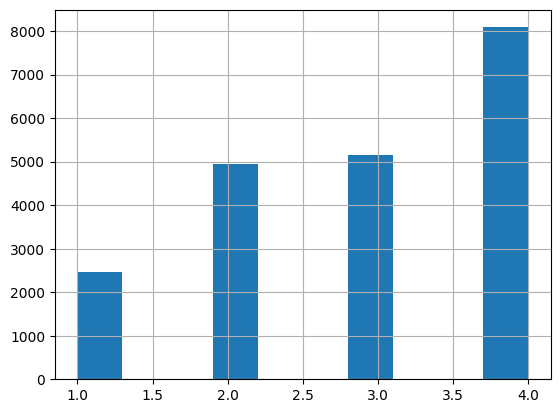

In [54]:
# check distribution in the bins
housing_num_enc_merged["income_cat"].hist()

In [ ]:
# když si budu hrát s hodnotama v bins při vytváření atributu, 
#tak můžu dostat víc vyrovnaný hodnoty, jakože ve sloupečcích bude podobný množství dat

In [ ]:
# housing_num_enc_merged["income_cat"] 

In [55]:
# Do stratified sampling based on the income category!
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for train_index, test_index in sss.split(housing_num_enc_merged, housing_num_enc_merged["income_cat"]):
    strat_train_set = housing_num_enc_merged.loc[train_index]
    strat_test_set = housing_num_enc_merged.loc[test_index]

# data 42x krát rozdělím a pak to procházím a dělám stratifikaci podle atributu income_cat

In [56]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,income_cat
5838,-118.36,34.20,14.0,1878.0,614.0,1874.0,559.0,2.5267,231800.0,3.359571,0.326944,3.352415,1.0,0.0,0.0,0.0,0.0,2
1985,-120.79,38.70,13.0,5036.0,1034.0,2243.0,923.0,2.3319,138500.0,5.456121,0.205322,2.430119,0.0,1.0,0.0,0.0,0.0,2
13526,-117.30,34.18,28.0,2685.0,425.0,1304.0,420.0,4.3676,111100.0,6.392857,0.158287,3.104762,0.0,1.0,0.0,0.0,0.0,4
18037,-121.91,37.23,27.0,4866.0,668.0,1956.0,659.0,7.3843,405000.0,7.383915,0.137279,2.968134,1.0,0.0,0.0,0.0,0.0,4
12494,-121.47,38.57,50.0,3233.0,968.0,1223.0,837.0,1.2041,168100.0,3.862605,0.299412,1.461171,0.0,1.0,0.0,0.0,0.0,1


In [57]:
# the income category proportions in the test set
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
4    0.391764
3    0.249516
2    0.239632
1    0.119089
Name: count, dtype: float64

In [58]:
# the income category proportions in the full housing dataset
housing_num_enc_merged["income_cat"].value_counts() / len(housing_num_enc_merged)

# poměr kolik prvků je v každé kategorii

income_cat
4    0.391812
3    0.249516
2    0.239632
1    0.119041
Name: count, dtype: float64

### Is there a balance?

In [ ]:
# yes there is, we have well stratified data

# 4. Select and train a model 

In [59]:
# Prepare training data 
X_train = strat_train_set.drop('median_house_value', axis=1)
y_train = strat_train_set['median_house_value']

In [60]:
# and testing data 
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value']

### Linear relationship? 

In [61]:
# Model 
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [62]:
# Evaluating: training MAE 
housing_predictions = lin_reg.predict(X_train)
lin_mae = mean_absolute_error(y_train, housing_predictions)
print(f'Linear model training MAE: {lin_mae}') 

Linear model training MAE: 48666.30243548084


In [63]:
# Evaluating: testing MAE 
housing_test_predictions = lin_reg.predict(X_test)
lin_mae_test = mean_absolute_error(y_test, housing_test_predictions)
print(f'Linear model testing MAE: {lin_mae_test}') 

Linear model testing MAE: 49339.675140695115


In [64]:
print(f'Median relative error: {round(lin_mae / y_train.median() * 100., 2)} %') 

Median relative error: 27.1 %


In [ ]:
# we assume that linear model is underfitting

### Non-linear relationship? 

In [65]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [66]:
# Evaluating: training MAE 
housing_predictions = tree_reg.predict(X_train)
tree_mae = mean_absolute_error(y_train, housing_predictions)
print(f'Tree model training MAE: {tree_mae}') 

Tree model training MAE: 0.0


In [67]:
# Evaluating: testing MAE 
housing_test_predictions = tree_reg.predict(X_test)
tree_mae_test = mean_absolute_error(y_test, housing_test_predictions)
print(f'Tree model testing MAE: {tree_mae_test}') 

Tree model testing MAE: 46312.28052325582


#### What does it mean? 

In [68]:
print(f'Median relative error: {round(tree_mae / y_train.median() * 100., 2)} %') 

Median relative error: 0.0 %


In [ ]:
# prefect overfitting

# Fine-tune the model

In [69]:
# Try Random Forest 
forest_reg = RandomForestRegressor(random_state=42)

In [70]:
# Combinations for Grid Search Cross-validation 
hyperparameter_space = {'n_estimators': [20, 50, 100], # no. of trees the model is computing
                        'max_depth': [10, 15, 20], # the higher the depth, the more you overfit
                        'min_samples_leaf': [2, 4]
                        }

gs = GridSearchCV(forest_reg, param_grid=hyperparameter_space, n_jobs=4,
                  scoring="neg_mean_absolute_error", cv=10, return_train_score=True)

# 10x to rozdělí subset na train a test

In [71]:
# run fit (be aware: TAKES LONG!)
gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=4,
             param_grid={'max_depth': [10, 15, 20], 'min_samples_leaf': [2, 4],
                         'n_estimators': [20, 50, 100]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [72]:
# Optimal parameters and scores 
print("Optimal hyperparameter combination: ", gs.best_params_)

Optimal hyperparameter combination:  {'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 100}


In [73]:
feature_importances = gs.best_estimator_.feature_importances_

In [74]:
# feature_importances
sorted(zip(feature_importances, list(X_train.columns)), reverse=True)

[(0.4954925240636981, 'median_income'),
 (0.1439795575573574, 'ocean_proximity_INLAND'),
 (0.11460623150785003, 'population_per_household'),
 (0.056082402957046563, 'longitude'),
 (0.051807658124639853, 'latitude'),
 (0.04720329140090254, 'housing_median_age'),
 (0.022539156637370227, 'rooms_per_household'),
 (0.022004949971505993, 'bedrooms_per_room'),
 (0.011169501608710766, 'total_bedrooms'),
 (0.010902771811590392, 'population'),
 (0.01061731341101237, 'total_rooms'),
 (0.00827287667434618, 'households'),
 (0.002533108536559617, 'ocean_proximity_NEAR OCEAN'),
 (0.0012830521667685768, 'ocean_proximity_<1H OCEAN'),
 (0.001004113160797005, 'ocean_proximity_NEAR BAY'),
 (0.0004728370187076911, 'income_cat'),
 (2.8653391136607984e-05, 'ocean_proximity_ISLAND')]

In [75]:
gs.best_estimator_

RandomForestRegressor(max_depth=20, min_samples_leaf=2, random_state=42)

In [76]:
# Select final model and evaluate it with test set!
final_model = gs.best_estimator_

In [77]:
print("Mean cross-validated accuracy of the best_estimator: ", round((-gs.best_score_), 2))

Mean cross-validated accuracy of the best_estimator:  33385.41


In [78]:
# Evaluating: testing MAE 
housing_test_predictions = final_model.predict(X_test)
final_model_mae_test = mean_absolute_error(y_test, housing_test_predictions)
print(f'Final model testing MAE: {final_model_mae_test}') 

Final model testing MAE: 33821.318227455624


In [79]:
print(f'Median relative error: {round(final_model_mae_test / y_train.median() * 100., 2)} %') 

Median relative error: 18.83 %
